In [1]:
# #Imports
# #Dataprep
# import matplotlib.pyplot as plt
# import numpy as np
# from nilearn import datasets, plotting, image
# from nilearn.maskers import NiftiMapsMasker
# from sklearn.decomposition import FastICA
# import pandas as pd
# import tarfile
# import gzip
# #sim required
# import random
# import pingouin as pg
# import seaborn as sns
# #GNN required
# import torch
# import torch.nn.functional as F
# from torch.nn import Linear
# import torch.nn as nn
# import torch_geometric
# from torch_geometric.nn import GCNConv
# from torch_geometric.nn import SAGEConv
# from torch_geometric.nn import GraphConv
# from torch_geometric.data import Data
# from torch_geometric.loader import DataLoader
# from torch.utils.data import SubsetRandomSampler
# from sklearn.metrics import accuracy_score

# STEP 1. Input Data Selection

**Deliverables:**  
**Goal**: Create different sub-graphs two decrease training times and aid in overall interpretability of GNN performance

**Sub-graph Types**
1. Significant Regions [alpha] 
2. Significant Regions [bonferroni-corrected] 
3. Graph Sampling [GRAPHSaint]

In [2]:
# imports for this section
from ast import literal_eval
import re
import gzip
import pandas as pd
import numpy as np
import torch

C:\Users\dfabe\AppData\Local\Temp\ipykernel_23680\2238771519.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## I. Read in the HCP data

In [3]:
data_file = 'Data/data_clean.csv.gz'

with gzip.open(data_file) as filepath:
    data = pd.read_csv(filepath, index_col = 'subject_id', 
            converters = {'netmat' : lambda x : np.array(literal_eval(re.sub('(?<!\[)\s+|[\\n]', ', ', x)))})

data.head()

,Gender,Age,netmat
subject_id,,,
100206,M,26-30,"[[0.0, 0.61676, 9.5727, -5.4959, 0.34639, 3.00..."
100307,F,26-30,"[[0.0, -0.29664, 17.317, -9.0467, -0.28723, 1...."
100408,M,31-35,"[[0.0, 1.6486, 6.6189, -8.8877, 1.4337, 1.006,..."
100610,M,26-30,"[[0.0, -0.90275, 7.7215, -8.3907, 3.3144, 2.93..."
101006,F,31-35,"[[0.0, -0.088768, 9.4979, -10.412, 1.0646, 4.3..."


## II. Get the input subgraphs

In [4]:
# STEP 1: INPUT DATA TYPES
# -> FILTERING
# 1. Sig Regions [alpha] 
# 2. Sig Regions [bonferroni-corrected] 
# 3. Graph Sampling [GRAPHSaint]

In [5]:
%%time
# full dataset
graphs = np.stack(data.netmat.to_numpy()) # all 1003 correlation matrices
edges = np.argwhere(graphs)
# significant edges
edges_sig = np.triu(np.genfromtxt('significant_edges.csv', delimiter=',')) # only keep unique edges
# bonferroni significant edges
edges_sig_b = np.triu(np.genfromtxt('bonferroni_sig_edges.csv', delimiter=',')) # only keep unique edges

CPU times: total: 344 ms
Wall time: 683 ms


In [6]:
# get edges into correct format for later
edges_sig = torch.tensor(np.argwhere(edges_sig).T)
edges_sig_b = torch.tensor(np.argwhere(edges_sig_b).T)

In [7]:
# labels
data['Gender'] = data['Gender'].replace({"M":0, "F":1})
labels = torch.tensor(data['Gender'].values)

C:\Users\dfabe\AppData\Local\Temp\ipykernel_23680\1997748793.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Gender'] = data['Gender'].replace({"M":0, "F":1})


In [8]:
labels

tensor([0, 1, 0,  ..., 1, 0, 1])

## III. Train-Validate-Test split

In [10]:
# imports for this section
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import SubsetRandomSampler
from sklearn.metrics import accuracy_score

In [11]:
def collate(data_list):
    """
    Unpacks graphs and their corresponding labels from a list of tuples.

    Parameters:
    - data_list (list of tuples): A list where each tuple contains a graph and its corresponding label.

    Returns:
    A dictionary with the following keys:
    - 'graph' (list): A list containing all the graphs extracted from the tuples.
    - 'label' (list): A list containing all the labels extracted from the tuples.
    """
    graphs, labels = map(list, zip(*data_list))
    return {
        'graph': graphs,
        'label': labels
    }
 

In [12]:
class CorrelationDataset(torch.utils.data.Dataset):
    def __init__(self, netmats, edges, labels, split_ratio=(0.8, 0.1, 0.1)):
        """
        Initializes the dataset with pairwise correlation matrices, labels, and edges.
    
        Parameters:
        - netmats (array-like): Pairwise correlation matrices.
        - edges (array-like): Regions that make up each pairwise correlation from `netmats`.
        - labels (array-like): Labels indicating gender (0 for male, 1 for female).
        - split_ratio (tuple): Ratios for splitting the data into train, validation, and test sets. Default is (0.8, 0.1, 0.1).
    
        Splits the data into training, validation, and test sets based on the specified split ratios.
        """
        self.netmats = netmats # pairwise correlation matrix
        self.labels = labels # female (1) or male (0)
        self.edges = edges # regions that make up each pairwise correlation from `netmats`
        self.split_ratios = split_ratio
        tot = len(self.netmats)
        train_samples = int(split_ratio[0] * tot) # 0.8
        val_samples = int(split_ratio[1] * tot) # 0.1

        # splitting the data
        self.train_indices = np.arange(0, train_samples) # training data
        self.val_indices = np.arange(train_samples, train_samples + val_samples) # validation data
        self.test_indices = np.arange(train_samples + val_samples, tot) # test data

    def __len__(self):
        """
        Returns the length of entire dataset (train + validate + test)
        """
        return len(self.netmats)

    def __getitem__(self, idx):
        """
        Retrieves the data and label corresponding to the given index.
    
        Parameters:
        - idx (int): Index of the data sample to retrieve.
    
        Returns:
        - graph_data (torch_geometric.data.Data): Graph data containing the correlation matrix and edge indices.
        - label (int): Label indicating the gender (0 for male, 1 for female) of the corresponding data sample.
        """
        x = torch.tensor(self.netmats[idx]).float() # correlation matrix
        edge_index = self.edges # dependent on input subgraph
        graph_data = Data(x=x, edge_index=edge_index) 
        label = self.labels[idx]
        return graph_data, label

    def get_split(self, idx):
        """
        Determines the split of a data sample based on its index.
    
        Parameters:
        - idx (int): Index of the data sample.
    
        Returns:
        - split (str): The split of the data sample ('train', 'val', or 'test').
    
        Raises:
        - ValueError: If the index is not found in any of the splits.
        """
        if idx in self.train_indices:
            return 'train'
        elif idx in self.val_indices:
            return 'val'
        elif idx in self.test_indices:
            return 'test'
        else:
            raise ValueError('Index not in any split')

In [13]:
def create_dataset(netmats, edges, labels=labels, collate_fn=collate):
    """
    Creates a dataset and corresponding data loaders for training, validation, and testing.

    Parameters:
    - netmats (array-like): Pairwise correlation matrices.
    - edges (array-like): Regions that make up each pairwise correlation from `netmats`.
    - labels (array-like): Labels indicating gender (0 for male, 1 for female).
    - collate_fn (function, optional): Function to collate data samples into batches. Default is `collate`.

    Returns:
    A dictionary containing the following keys:
    - 'dataset' (CorrelationDataset): The created dataset.
    - 'train_loader' (torch.utils.data.DataLoader): DataLoader for training data.
    - 'validate_loader' (torch.utils.data.DataLoader): DataLoader for validation data.
    - 'test_loader' (torch.utils.data.DataLoader): DataLoader for test data.
    """
    dataset = CorrelationDataset(netmats, edges, labels, split_ratio=(0.8, 0.1, 0.1))
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.train_indices), collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.val_indices), collate_fn=collate_fn)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SubsetRandomSampler(dataset.test_indices), collate_fn=collate_fn)
    return {
        'dataset': dataset,
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader
    }

In [14]:
%%time
# train-validate-test splits
# full dataset
# full =  create_dataset(graphs, edges.T)
# significant pairwise correlations only
sig = create_dataset(graphs, edges_sig)
# bonferroni significant pairwise correlations only
# sig_b = create_dataset(graphs, np.argwhere(edges_sig_b).T)

CPU times: total: 0 ns
Wall time: 0 ns


In [15]:
foo = iter(sig['train_loader'])
next(foo)

{'graph': [Data(x=[100, 100], edge_index=[2, 1695])], 'label': [tensor(0)]}

# STEP 2. Model Development

In [160]:
# new imports for this section
import matplotlib.pyplot as plt

In [161]:
def train(model, data_loader, device, loss_fn, optimizer):
    model.train()
    total_loss = 0
    num_corr = 0
    num_female_guesses = 0
    for d in data_loader:
        m = d['graph'][0]
        m = m.to(device)
        label = d['label'][0]
        optimizer.zero_grad()
        out = model(d).squeeze()
        loss = loss_fn(out.float(), label.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        pred = (out.double() > 0.5).float()
        if pred == label.double():
            num_corr += 1
        if pred == 1:
            num_female_guesses += 1 
    return total_loss, num_corr, num_female_guesses

def eval(model, loader, device):
    model.eval()
    tp, fp, tn, fn = 0, 0, 0, 0, 0, 0
    m = 0
    f = 1
    
    for d in loader:
        with torch.no_grad():
            out = model(d)
            pred = (out.double() > 0.5).float()

        # metrics pre-liminary calculations
        y = d['label'][0] # actual labels
        tp += (pred == f) & (y == f) # pred: f, actual: f
        fp += (pred == f) & (y == m) # pred: f, actual: m
        tn += (pred == m) & (y == m) # pred: m, actual: m
        fn += (pred == m) & (y == f) # pred: m, actual: f

        # metrics calculations
        prec = tp / (tp + fp) # precision (tp / tp + fp) 
        rec = tp / (tp + fn) # recall (tp / tp + fn)
        acc = tp + tn / (tp + fp + tn + fn) # accuracy (tp + tn / tp + tn + fp + fn)  
        
    return prec, rec, acc 

def plot_eval(precs, recalls, accs):
    t = 0
    v = 1
    
    # plot precisions
    plt.plot(precs[t], color='blue')
    plt.plot(precs[v], color='green')
    plt.title('Precisions Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.show()
    
    # plot recalls
    plt.plot(recalls[t], color='blue')
    plt.plot(recalls[v], color='green')
    plt.title('Recalls Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.grid(True)
    plt.show()
    
    # plot accuracies
    plt.plot(accs[t], color='blue')
    plt.plot(accs[v], color='green')
    plt.title('Accuracies Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    return

In [162]:
def train_validate_model(model, optimizer, criterion, dataset, num_epochs=50):
    train_data = 'train_loader'
    val_data = 'val_loader'
    test_data = 'test_loader'

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    losses = np.zeros(num_epochs) 
    precs = [np.zeros(num_epochs)] * 2 # one list for training, and another for validation
    recalls = [np.zeros(num_epochs)] * 2
    accs = [np.zeros(num_epochs)] * 2
    for epoch in range(num_epochs):
        # model training and validation
        t = 0 
        v = 1
        losses[epoch], num_corr, num_female_guesses = train(model, dataset[train_data], device, criterion, optimizer)
        precs[t][epoch], recalls[t][epoch], accs[t][epoch] = eval(model, dataset[train_data], device)
        precs[v][epoch], recalls[v][epoch], accs[v][epoch] = eval(model, dataset[val_data], device)

        avg_loss = losses[epoch] / len(sig[train_data])
        # display model performance metrics
        print(f'Epoch: {epoch + 1}/{num_epochs}, '
              f'Loss: {losses[epoch]}, '
              f'Avg Loss: {avg_loss:.3f}, '
              f'Train: {100 * accs[t][epoch]:.2f}%, '
              f'Validation: {100 * accs[v][epoch]:.2f}%, '
              f'Num Correct: {num_corr}, '
              f'Female Guesses: {num_female_guesses} ')
    return losses, precs, recalls, accs, avg_loss

In [163]:
# GNN from Application/GNN
class GCN(nn.Module):
    def __init__(self,):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(100, 150)
        self.bn1 = nn.BatchNorm1d(150)
        self.conv2 = GCNConv(150, 50)
        self.bn2 = nn.BatchNorm1d(50)
        self.classifier = Linear(50, 1)

    def forward(self, data):
        data = data['graph'][0]
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=0.75)(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=0.75)(x)
        x = self.classifier(x).mean(dim=0)
        x = torch.sigmoid(x)
        return x
    
model = GCN()
print(model)

GCN(
  (conv1): GCNConv(100, 150)
  (bn1): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(150, 50)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Linear(in_features=50, out_features=1, bias=True)
)


## Training model with lr=0.005

In [164]:
loss1, prec1, recall1, acc1, avg_loss1= train_validate_model(
    model=model, 
    optimizer=torch.optim.Adam(model.parameters(), lr=0.005), 
    criterion=nn.BCELoss(), 
    dataset=sig)

Epoch: 1/50, Loss: 552.4673542976379, Avg Loss: 0.689, Train: 53.00%, Validation: 53.00%, Num Correct: 440, Female Guesses: 632 
Epoch: 2/50, Loss: 553.9804979562759, Avg Loss: 0.691, Train: 43.00%, Validation: 43.00%, Num Correct: 434, Female Guesses: 632 
Epoch: 3/50, Loss: 557.8255046308041, Avg Loss: 0.696, Train: 44.00%, Validation: 44.00%, Num Correct: 427, Female Guesses: 671 
Epoch: 4/50, Loss: 550.2960745692253, Avg Loss: 0.686, Train: 38.00%, Validation: 38.00%, Num Correct: 440, Female Guesses: 592 
Epoch: 5/50, Loss: 539.2399357706308, Avg Loss: 0.672, Train: 43.00%, Validation: 43.00%, Num Correct: 468, Female Guesses: 550 
Epoch: 6/50, Loss: 520.087557092309, Avg Loss: 0.648, Train: 43.00%, Validation: 43.00%, Num Correct: 504, Female Guesses: 518 
Epoch: 7/50, Loss: 489.13026358932257, Avg Loss: 0.610, Train: 52.00%, Validation: 52.00%, Num Correct: 541, Female Guesses: 483 
Epoch: 8/50, Loss: 457.01290015503764, Avg Loss: 0.570, Train: 44.00%, Validation: 44.00%, Num Co

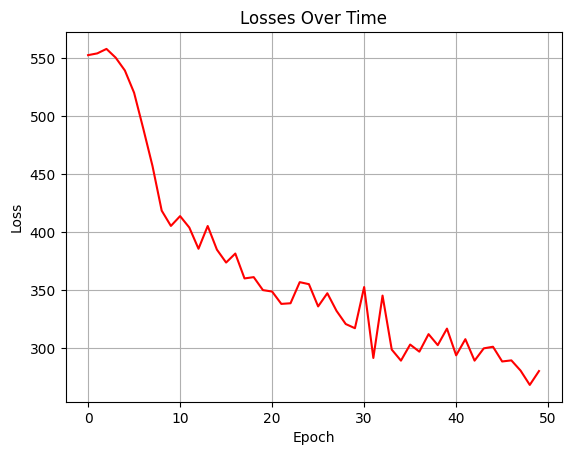

0.3495866588966868


In [184]:
plt.plot(loss1, color='red')
plt.title('Losses Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

print(avg_loss1)

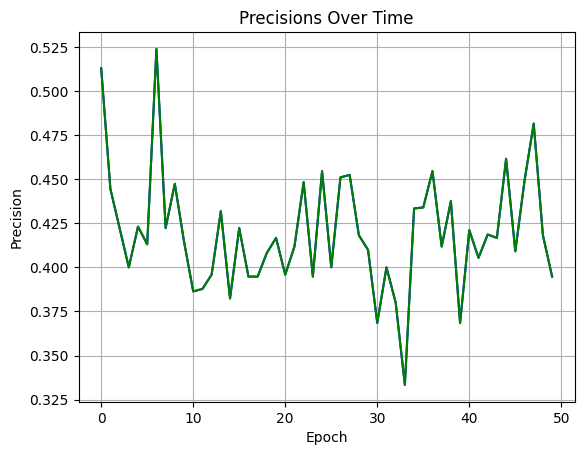

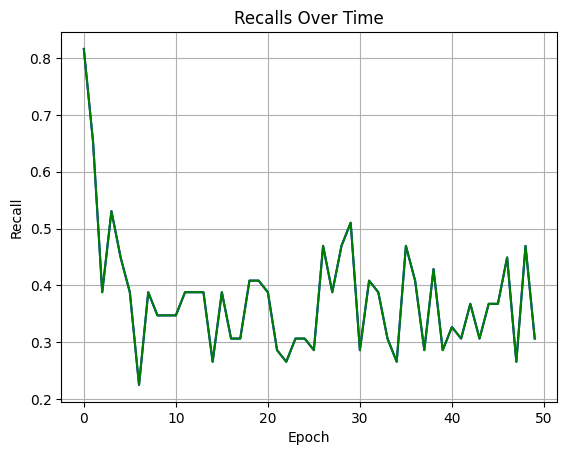

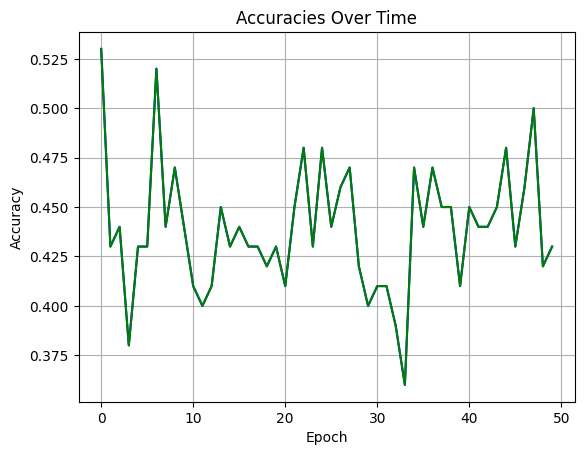

In [180]:
plot_eval(prec1, recall1, acc1)

In [165]:
# same model, adjusted learning rate
loss2, prec2, recall2, acc2, avg_loss2= train_validate_model(
    model=model, 
    optimizer=torch.optim.Adam(model.parameters(), lr=0.003), 
    criterion=nn.BCELoss(), 
    dataset=sig)

Epoch: 1/50, Loss: 260.9136020670703, Avg Loss: 0.325, Train: 49.00%, Validation: 49.00%, Num Correct: 688, Female Guesses: 430 
Epoch: 2/50, Loss: 254.64251564102597, Avg Loss: 0.318, Train: 45.00%, Validation: 45.00%, Num Correct: 696, Female Guesses: 434 
Epoch: 3/50, Loss: 257.7212147981627, Avg Loss: 0.321, Train: 40.00%, Validation: 40.00%, Num Correct: 692, Female Guesses: 432 
Epoch: 4/50, Loss: 249.09747152755153, Avg Loss: 0.311, Train: 46.00%, Validation: 46.00%, Num Correct: 690, Female Guesses: 434 
Epoch: 5/50, Loss: 266.626058159105, Avg Loss: 0.332, Train: 44.00%, Validation: 44.00%, Num Correct: 684, Female Guesses: 442 
Epoch: 6/50, Loss: 253.46280826552538, Avg Loss: 0.316, Train: 44.00%, Validation: 44.00%, Num Correct: 695, Female Guesses: 433 
Epoch: 7/50, Loss: 219.27882796269841, Avg Loss: 0.273, Train: 45.00%, Validation: 45.00%, Num Correct: 715, Female Guesses: 445 
Epoch: 8/50, Loss: 245.00508753189933, Avg Loss: 0.305, Train: 47.00%, Validation: 47.00%, Num

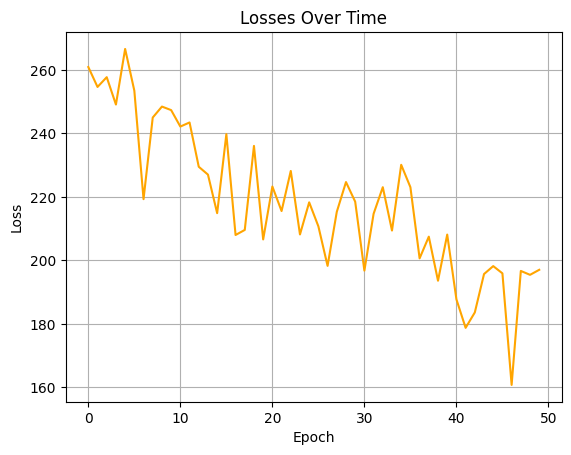

0.24565648240881946


In [185]:
# plot loss
plt.plot(loss2, color='orange')
plt.title('Losses Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show() # slower learning rate

print(avg_loss2)

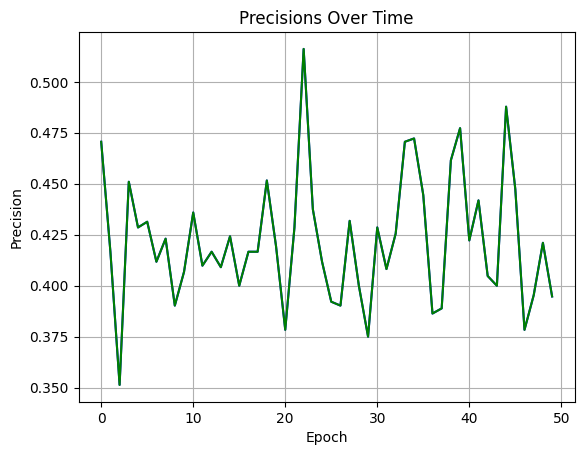

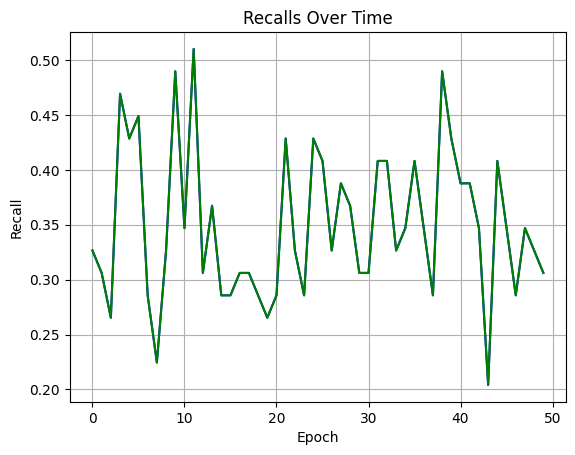

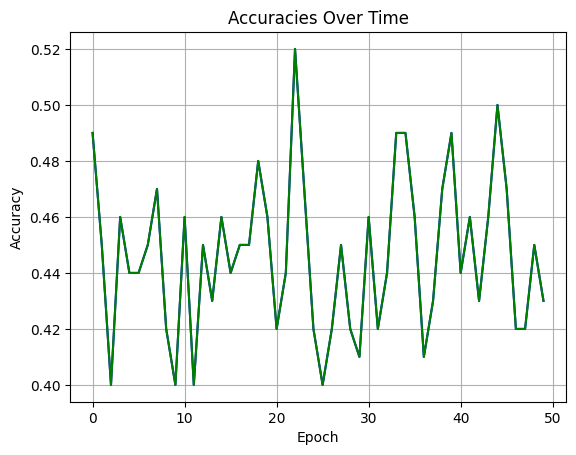

In [181]:
plot_eval(prec2, recall2, acc2) # slower learning rate

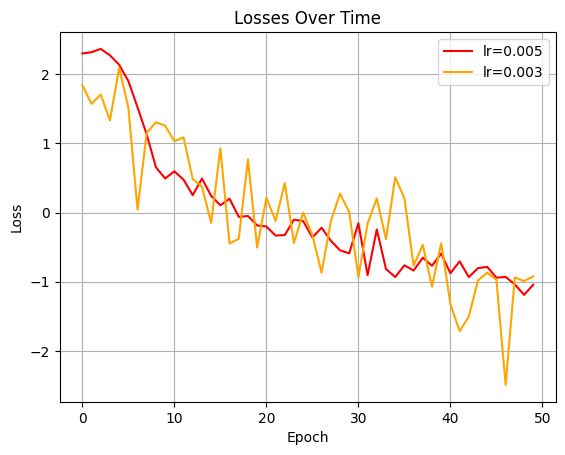

In [183]:
def z_score_normalization(array):
    # Calculate mean and standard deviation
    mean = np.mean(array)
    std_dev = np.std(array)
    
    # Z-score normalization
    normalized_array = (array - mean) / std_dev
    
    return normalized_array

# Perform Z-score normalization
normalized_loss1 = z_score_normalization(loss1)
normalized_loss2 = z_score_normalization(loss2)

plt.plot(normalized_loss1, color='red', label='lr=0.005')
plt.plot(normalized_loss2, color='orange', label='lr=0.003')
plt.title('Losses Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [167]:
# 2-layer models

class twoGCN_custom(nn.Module):
    """
    Graph Convolutional Network (GCN) with customizable hyperparameters.

    Args:
        input_dim (int): Dimension of the input features.
        hidden_dim1 (int): Dimension of the first hidden layer.
        hidden_dim2 (int): Dimension of the second hidden layer.
        output_dim (int): Dimension of the output.
        dropout_prob (float): Dropout probability.

    Attributes:
        conv1 (GCNConv): First graph convolutional layer.
        bn1 (BatchNorm1d): Batch normalization layer for the first hidden layer.
        conv2 (GCNConv): Second graph convolutional layer.
        bn2 (BatchNorm1d): Batch normalization layer for the second hidden layer.
        classifier (Linear): Linear layer for classification.
        dropout_prob (float): Dropout probability.

    """
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, dropout_prob):
        super(twoGCN_custom, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.classifier = Linear(hidden_dim2, 1) # output dimension will always be 1
        self.dropout_prob = dropout_prob

    def forward(self, data):
        data = data['graph'][0]
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=self.dropout_prob)(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.tanh(x)
        x = nn.Dropout(p=self.dropout_prob)(x)
        x = self.classifier(x).mean(dim=0)
        x = torch.sigmoid(x)
        return x

In [168]:
twoGCN_1 = twoGCN_custom(
    input_dim=100,
    hidden_dim1=150, 
    hidden_dim2=50, 
    dropout_prob=0.50
)
print(twoGCN_1)
loss3, prec3, recall3, acc3, avg_loss3 = train_validate_model(
    model=twoGCN_1, 
    optimizer=torch.optim.Adam(model.parameters(), lr=0.003), 
    criterion=nn.BCELoss(), 
    dataset=sig)

twoGCN_custom(
  (conv1): GCNConv(100, 150)
  (bn1): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(150, 50)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Linear(in_features=50, out_features=1, bias=True)
)
Epoch: 1/50, Loss: 553.614551961422, Avg Loss: 0.690, Train: 46.00%, Validation: 46.00%, Num Correct: 436, Female Guesses: 798 
Epoch: 2/50, Loss: 553.5955839157104, Avg Loss: 0.690, Train: 49.00%, Validation: 49.00%, Num Correct: 434, Female Guesses: 802 
Epoch: 3/50, Loss: 553.2742046713829, Avg Loss: 0.690, Train: 46.00%, Validation: 46.00%, Num Correct: 434, Female Guesses: 798 
Epoch: 4/50, Loss: 554.1525685191154, Avg Loss: 0.691, Train: 51.00%, Validation: 51.00%, Num Correct: 434, Female Guesses: 802 
Epoch: 5/50, Loss: 553.812405705452, Avg Loss: 0.691, Train: 48.00%, Validation: 48.00%, Num Correct: 434, Female Guesses: 800 
Epoch: 6/50, Loss: 552.9990044236183, 

KeyboardInterrupt: 

In [ ]:
# plot loss
plt.plot(loss3, color='red')
plt.title('Losses Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plot_eval(prec3, recall3, acc3)

In [ ]:
# high droup-out leads to better performance, let's take a look at the dataset to try and assess why:
# dataset descriptor
sig_dataset = sig['dataset']
print(sig_dataset)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {sig_dataset.netmats[0].shape[0]}')
print(f'Number of edges: {sig_dataset.edges.shape[1]}')
print(f'Average node degree: {sig_dataset.edges.shape[1] / sig_dataset.netmats[0].shape[0]:.2f}')

## from https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
**Use a Larger Network**  

It is common for larger networks (more layers or more nodes) to more easily overfit the training data.

When using dropout regularization, it is possible to use larger networks with less risk of overfitting. In fact, a large network (more nodes per layer) may be required as dropout will probabilistically reduce the capacity of the network.

A good rule of thumb is to divide the number of nodes in the layer before dropout by the proposed dropout rate and use that as the number of nodes in the new network that uses dropout. For example, a network with 100 nodes and a proposed dropout rate of 0.5 will require 200 nodes (100 / 0.5) when using dropout.

In [ ]:
dropout = 0.75

twoGCN_2 = twoGCN_custom(
    input_dim=100,
    hidden_dim1=200, # Convolutional layer 1 [100 -> 200] *before dropout
    hidden_dim2=70, # Convolutional layer 2 [200 -> 70] *before dropout 
    dropout_prob=0.75
)
print(twoGCN_2)
loss4, prec4, recall4, acc4, avg_loss4 = train_validate_model(
    model=twoGCN_2,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.003), # slightly higher learning rate
    criterion=nn.BCELoss(), 
    dataset=sig
)

In [ ]:
# plot loss
plt.plot(loss4, color='red')
plt.title('Losses Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plot_eval(prec4, recall4, acc4)

The model performed much worse with LESS sparse layers

In [ ]:
# twoGCN_1 = twoGCN_custom(
#     input_dim=100,
#     hidden_dim1=150, 
#     hidden_dim2=50, 
#     dropout_prob=0.50,
#     activation_functions=[torch.tanh, torch.tanh]
# )
# print(twoGCN_1)
# train_validate_model(model=twoGCN_1, optimizer=torch.optim.Adam(model.parameters(), lr=0.003), criterion=nn.BCELoss(), dataset=sig)

In [ ]:
# twoGCN_3 = twoGCN_custom(
#     input_dim=100, 
#     hidden_dim1=150, 
#     hidden_dim2=50, 
#     dropout_prob=0.50,
#     activation_functions=[tanh, tanh]
# )
# print(twoGCN_2)
# train_validate_model(model=twoGCN_3, optimizer=torch.optim.Adam(model.parameters(), lr=0.003), criterion=nn.BCELoss(), dataset=sig)